In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Exploratory Analysis and Feature Engineering

In [3]:
train_df.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
289,290,1,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q
285,286,0,3,"Stankovic, Mr. Ivan",male,33.0,0,0,349239,8.6625,NaN,C
108,109,0,3,"Rekic, Mr. Tido",male,38.0,0,0,349249,7.8958,NaN,S
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S
873,874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S
769,770,0,3,"Gronnestad, Mr. Daniel Danielsen",male,32.0,0,0,8471,8.3625,NaN,S
705,706,0,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.0000,NaN,S
604,605,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35.0,0,0,111426,26.5500,NaN,C
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin and Embarked have missing data. Need to drop or impute these values before model training. First let's look at variable relationships.

In [6]:
survivors = train_df.loc[train_df['Survived']==True]
deceased = train_df.loc[train_df['Survived']==False]

Let's investigate each variable's relationship with 'Survived':

In [7]:
deceased['Sex'].value_counts()

male      468
female     81
Name: Sex, dtype: int64

In [8]:
survivors['Sex'].value_counts()

female    233
male      109
Name: Sex, dtype: int64

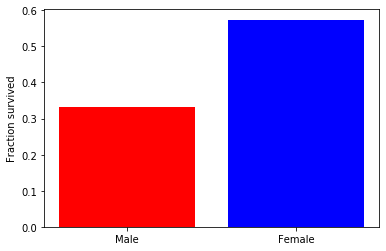

In [9]:
male_deceased = deceased['Sex'].value_counts()[0]
male_survived = survivors['Sex'].value_counts()[0]
male_total = male_survived + male_deceased
male_frac_survived = male_survived/male_total

female_deceased = deceased['Sex'].value_counts()[1]
female_survived = survivors['Sex'].value_counts()[1]
female_total = female_survived + female_deceased
female_frac_survived = female_survived/female_total

fig, ax = plt.subplots()
ax.bar('Male', male_frac_survived, color='r')
ax.bar('Female', female_frac_survived, color='b')
ax.set_ylabel('Fraction survived')
plt.show()

Gender looks like a fairly strong indicator, with women more likely to have survived.

Let's examine other variables:

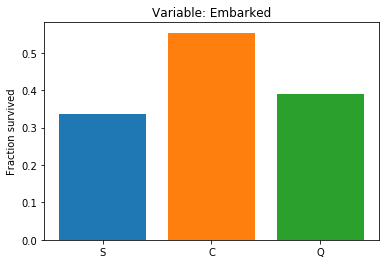

In [10]:
var = 'Embarked'
unique_values = pd.DataFrame(train_df[var].unique())
unique_values.dropna(inplace=True)
count_data = np.zeros((len(unique_values),3))

for series_idx, series in enumerate([deceased, survivors]):
    for val_idx, val in enumerate(series[var].unique()):
        if val_idx+1 > len(unique_values):
            continue
        else:
            count_data[val_idx, series_idx] = series[var].value_counts().iloc[val_idx]        
plot_data = count_data[:,1]/(count_data[:,0]+count_data[:,1])

fig, ax = plt.subplots()
for i, cell in enumerate(plot_data):
    ax.bar(x=unique_values.iloc[i],height=cell)
ax.set_title('Variable: {}'.format(var))
ax.set_ylabel('Fraction survived')
plt.show()

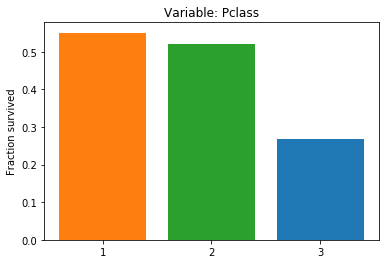

In [11]:
var = 'Pclass'
unique_values = pd.DataFrame(train_df[var].unique())
unique_values.dropna(inplace=True)
count_data = np.zeros((len(unique_values),3))

for series_idx, series in enumerate([deceased, survivors]):
    for val_idx, val in enumerate(series[var].unique()):
        if val_idx+1 > len(unique_values):
            continue
        else:
            count_data[val_idx, series_idx] = series[var].value_counts().iloc[val_idx]        
plot_data = count_data[:,1]/(count_data[:,0]+count_data[:,1])

fig, ax = plt.subplots()
for i, cell in enumerate(plot_data):
    ax.bar(x=unique_values.iloc[i],height=cell)
ax.set_title('Variable: {}'.format(var))
ax.set_ylabel('Fraction survived')
ax.set_xticks([1, 2, 3])
plt.show()

Learnings:

- If you are in class 3 you are more likely to have died. If you are in 1, you are more likely to have survived. in 2 it's roughly 50:50
- If you embarked at 'C' you are more likely to have survived. Of course, this may be because that more women and children embarked at 'C' in relative terms (or other similar group cross section arguments).

Let's look at the 'Cabin' entries

In [12]:
print(train_df['Cabin'].dropna().sample(n=25))

621            D19
345            F33
183             F4
331           C124
166            E33
215            D36
356            E33
505            C65
27     C23 C25 C27
745            B22
339              T
806            A36
849            C92
839            C47
327              D
92             E31
248            D35
139            B86
438    C23 C25 C27
194             B4
662            E58
319            E34
366            D37
618             F4
185            A32
Name: Cabin, dtype: object


In [13]:
print(train_df['Cabin'].isnull().value_counts())

True     687
False    204
Name: Cabin, dtype: int64


These data entries look very incomplete, let's drop the 'Cabin' variable

In [14]:
train_df.drop(['Cabin'], axis=1, inplace=True)
test_df.drop(['Cabin'], axis=1, inplace=True)

In [15]:
train_df['Name'].sample(n=25)

338                        Dahl, Mr. Karl Edwart
22                   McGowan, Miss. Anna "Annie"
573                            Kelly, Miss. Mary
124                  White, Mr. Percival Wayland
673                        Wilhelms, Mr. Charles
775      Myhrman, Mr. Pehr Fabian Oliver Malkolm
634                           Skoog, Miss. Mabel
609                    Shutes, Miss. Elizabeth W
155                  Williams, Mr. Charles Duane
370                  Harder, Mr. George Achilles
547                   Padro y Manent, Mr. Julian
106             Salkjelsvik, Miss. Anna Kristine
406             Widegren, Mr. Carl/Charles Peter
341               Fortune, Miss. Alice Elizabeth
23                  Sloper, Mr. William Thompson
647          Simonius-Blumer, Col. Oberst Alfons
760                           Garfirth, Mr. John
60                         Sirayanian, Mr. Orsen
24                 Palsson, Miss. Torborg Danira
736      Ford, Mrs. Edward (Margaret Ann Watson)
852                 

There may be some insight from extracting the titles of the passengers. We can use regular expressions to extract the titles of the passengers

In [16]:
train_df['Title'] = ""
test_df['Title'] = ""

title_pattern = re.compile(', [A-Za-z]+\.')
for index, row in train_df.iterrows():
    title_match = title_pattern.search(row['Name'])
    if title_match: 
        train_df['Title'].loc[index] = title_match.group(0)[2:-1]
        
for index, row in test_df.iterrows():
    title_match = title_pattern.search(row['Name'])
    if title_match: 
        test_df['Title'].loc[index] = title_match.group(0)[2:-1] 

C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
print(train_df['Title'].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Jonkheer      1
Mme           1
Ms            1
Lady          1
Sir           1
Don           1
Capt          1
              1
Name: Title, dtype: int64


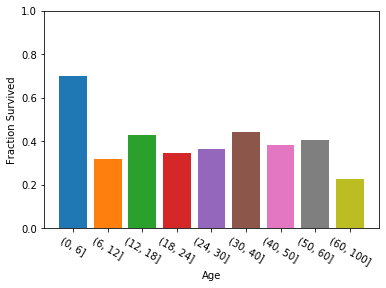

In [18]:
var = 'Age'
survivors_data = survivors[var].dropna()
deceased_data = deceased[var].dropna()
age_bins = [0, 6, 12, 18, 24, 30, 40, 50, 60, 100]

s_cut_data = pd.cut(survivors_data, age_bins)
d_cut_data = pd.cut(deceased_data, age_bins)
survivor_frac = s_cut_data.value_counts()/(s_cut_data.value_counts()+d_cut_data.value_counts())

fig, ax = plt.subplots()
for i, cell in enumerate(survivor_frac):
    ax.bar(x=str(survivor_frac.index[i]), height=cell, width=0.8)
plt.xticks(rotation=-30)
ax.set_ylim([0, 1])
ax.set_ylabel('Fraction Survived')
ax.set_xlabel('{}'.format(var))
plt.show()

Infants are more likely to have survived. Interesting that children are less likely to have survived (6 to 12y) relative to the general population.

Let's impute missing values for Age. I expect we can do so by correlating with other variables like Class, Title, SibSp and Parch

Text(0.5, 0, 'Title')

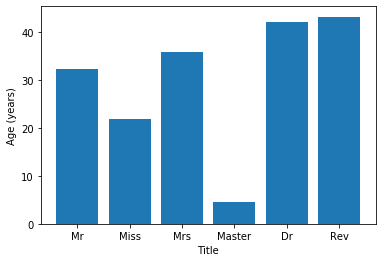

In [19]:
# Look at correlation between title and age
# only consider titles with > 2 entry counts
titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev']
mean_ages = []

for title in titles:
    mean_ages.append(train_df['Age'].loc[train_df['Title']==title].mean())

fig, ax = plt.subplots(1,1)
ax.bar(titles, mean_ages)
ax.set_ylabel('Age (years)')
ax.set_xlabel('Title')

Text(0.5, 0, 'Class')

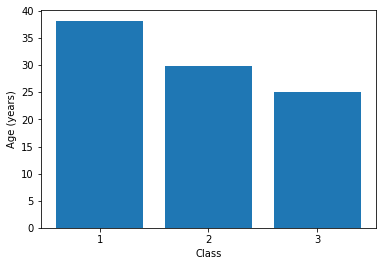

In [20]:
# Look at correlation between class and age
mean_ages = []

for Pclass in train_df['Pclass'].unique():
    mean_ages.append(train_df['Age'].loc[train_df['Pclass']==Pclass].mean())

fig, ax = plt.subplots(1,1)
ax.bar(train_df['Pclass'].unique(), mean_ages)
ax.set_xticks([1, 2, 3])
ax.set_ylabel('Age (years)')
ax.set_xlabel('Class')

Text(0.5, 0, 'SibSp')

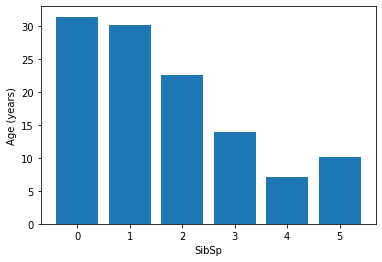

In [21]:
# Look at correlation between SibSp and age
mean_ages = []

for SibSp in train_df['SibSp'].unique():
    mean_ages.append(train_df['Age'].loc[train_df['SibSp']==SibSp].mean())

fig, ax = plt.subplots(1,1)
ax.bar(train_df['SibSp'].unique(), mean_ages)
#ax.set_xticks([1, 2, 3])
ax.set_ylabel('Age (years)')
ax.set_xlabel('SibSp')

Text(0.5, 0, 'Parch')

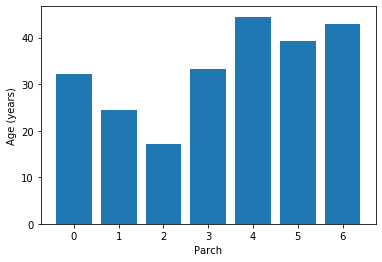

In [22]:
# Look at correlation between Parch and age
mean_ages = []

for Parch in train_df['Parch'].unique():
    mean_ages.append(train_df['Age'].loc[train_df['Parch']==Parch].mean())

fig, ax = plt.subplots(1,1)
ax.bar(train_df['Parch'].unique(), mean_ages)
ax.set_ylabel('Age (years)')
ax.set_xlabel('Parch')

In [23]:
# impute values for age
# using means of combinations of class and title

age_guess = np.zeros((train_df['Title'].unique().size, train_df['Pclass'].unique().size))
for i, title in enumerate(train_df['Title'].unique()):
    for j, cls in enumerate(train_df['Pclass'].unique()):
        age_guess[i,j] = train_df['Age'].loc[(train_df['Title']==title) & \
                                             (train_df['Pclass']==cls)].mean()
        train_df.loc[train_df['Age'].isnull() & (train_df['Title']==title) & \
                     (train_df['Pclass']==cls), 'Age'] = age_guess[i,j]
        
age_guess = np.zeros((test_df['Title'].unique().size, test_df['Pclass'].unique().size))
for i, title in enumerate(test_df['Title'].unique()):
    for j, cls in enumerate(test_df['Pclass'].unique()):
        age_guess[i,j] = test_df['Age'].loc[(test_df['Title']==title) & \
                                             (test_df['Pclass']==cls)].mean()
        test_df.loc[test_df['Age'].isnull() & (test_df['Title']==title) & \
                     (test_df['Pclass']==cls), 'Age'] = age_guess[i,j]

Finally, let's look at the two missing data points for Embarked

In [24]:
train_df.loc[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,Mrs


Let's check if the husband (father) is on board for the second entry

In [25]:
name_string = re.compile('George Nelson')
for index, row in train_df.iterrows():
    name_match = name_string.search(row['Name'])
    if name_match:
        print(row)

PassengerId                                          830
Survived                                               1
Pclass                                                 1
Name           Stone, Mrs. George Nelson (Martha Evelyn)
Sex                                               female
Age                                                   62
SibSp                                                  0
Parch                                                  0
Ticket                                            113572
Fare                                                  80
Embarked                                             NaN
Title                                                Mrs
Name: 829, dtype: object


He's not, which doesn't help with imputing the missing values.

In [26]:
train_df.loc[train_df['Embarked'] == 'S'].sample(n=15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
220,221,1,3,"Sunderland, Mr. Victor Francis",male,16.000000,0,0,SOTON/OQ 392089,8.0500,S,Mr
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,32.768293,0,0,239853,0.0000,S,Mr
313,314,0,3,"Hendekovic, Mr. Ignjac",male,28.000000,0,0,349243,7.8958,S,Mr
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,16.123188,8,2,CA. 2343,69.5500,S,Miss
664,665,1,3,"Lindqvist, Mr. Eino William",male,20.000000,1,0,STON/O 2. 3101285,7.9250,S,Mr
294,295,0,3,"Mineff, Mr. Ivan",male,24.000000,0,0,349233,7.8958,S,Mr
512,513,1,1,"McGough, Mr. James Robert",male,36.000000,0,0,PC 17473,26.2875,S,Mr
440,441,1,2,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.000000,1,1,F.C.C. 13529,26.2500,S,Mrs
831,832,1,2,"Richards, Master. George Sibley",male,0.830000,1,1,29106,18.7500,S,Master
582,583,0,2,"Downton, Mr. William James",male,54.000000,0,0,28403,26.0000,S,Mr


Let's assume they departed from Southampton. There doesn't appear to be a strong correlation between other variables and departure port, nor would we expect there to be.

In [27]:
train_df.loc[train_df['Embarked'].isnull(), 'Embarked'] = 'S'

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


One feature that could be revealing is a lady's marital status. Let's use regular expressions to create this column of data. We can always drop columns later on if they appear irrelevant or detrimental to model performance

In [29]:
married = re.compile(r'Mrs.')
single = re.compile(r'Miss')
death_count = {'single': 0, 'married': 0}
survivor_count = {'single': 0, 'married': 0}

for index, row in train_df.iterrows():
    married_mo = married.search(row['Name'])
    single_mo = single.search(row['Name'])
    if married_mo and row['SibSp']!=0 and row['Survived']==False:
        death_count['married'] += 1
    if married_mo and row['SibSp']!=0 and row['Survived']==True:
        survivor_count['married'] += 1
    if single_mo and row['SibSp']!=0 and row['Survived']==False:
        death_count['single'] += 1
    if single_mo and row['SibSp']!=0 and row['Survived']==True:
        survivor_count['single'] += 1

print("Married female counts")
print("Perished: " + str(death_count['married']))
print("Survived: " + str(survivor_count['married']) + "\n")
print("Single female counts")
print("Perished: " + str(death_count['single']))
print("Survived: " + str(survivor_count['single']) + "\n")

Married female counts
Perished: 18
Survived: 63

Single female counts
Perished: 26
Survived: 33



Single female survived ratio is similar to the overall for females (50 to 60%), but reasonably higher for females who are married but alone. Let's create PartySize and IsAlone variables.

In [30]:
train_df['PartySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = 0
train_df.loc[train_df['PartySize'] == 1, 'IsAlone'] = 1

test_df['PartySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['IsAlone'] = 0
test_df.loc[test_df['PartySize'] == 1, 'IsAlone'] = 1

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Title          891 non-null object
PartySize      891 non-null int64
IsAlone        891 non-null int64
dtypes: float64(2), int64(7), object(5)
memory usage: 97.6+ KB


Drop Ticket, Name and Id from the train dataset, as these are unique for each passenger

In [32]:
train_df.drop(['Ticket', 'Name', 'PassengerId'], axis=1, inplace=True)
test_df.drop(['Ticket', 'Name'], axis=1, inplace=True)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null object
Age          891 non-null float64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null float64
Embarked     891 non-null object
Title        891 non-null object
PartySize    891 non-null int64
IsAlone      891 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 76.7+ KB


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            417 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
Title          418 non-null object
PartySize      418 non-null int64
IsAlone        418 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


Need to impute missing value for age and fare in the test dataset

In [35]:
test_df.loc[test_df['Age'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,PartySize,IsAlone
88,980,3,female,NaN,0,0,7.75,Q,Ms,1,1


Low fare, low class, title Ms and is alone suggests a young woman. (c. 20). Let's see if there are any comparators

In [36]:
train_df.loc[train_df['Title']=='Ms']

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,PartySize,IsAlone
443,1,2,female,28.0,0,0,13.0,S,Ms,1,1


Let's also set her Age to 28

In [37]:
test_df.loc[test_df['Age'].isnull(), 'Age'] = 28

Now for the missing Fare

In [38]:
test_df.loc[test_df['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,PartySize,IsAlone
152,1044,3,male,60.5,0,0,NaN,S,Mr,1,1


Class is likely to be the largest determinant of Fare, let's set Fare to the median of this group

In [39]:
test_df.loc[test_df['Fare'].isnull(), 'Fare'] = train_df.loc[train_df['Pclass']==3, 'Fare'].median()

In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
Title          418 non-null object
PartySize      418 non-null int64
IsAlone        418 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


Finally, encode categorical variables

In [41]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [42]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,PartySize,IsAlone,Sex_female,Sex_male,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,0,3,22.0,1,0,7.2500,2,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,1,38.0,1,0,71.2833,2,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,3,26.0,0,0,7.9250,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,2,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,3,35.0,0,0,8.0500,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [43]:
test_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,PartySize,IsAlone,Sex_female,Sex_male,...,Embarked_S,Title_Col,Title_Dona,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rev
0,892,3,34.5,0,0,7.8292,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,893,3,47.0,1,0,7.0000,2,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,894,2,62.0,0,0,9.6875,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
3,895,3,27.0,0,0,8.6625,1,1,0,1,...,1,0,0,0,0,0,1,0,0,0
4,896,3,22.0,1,1,12.2875,3,0,1,0,...,1,0,0,0,0,0,0,1,0,0


Some titles only appear in the train dataset and some only appear in the test dataset. Both should contain the same independent variables (columns) so we need to drop or impute values to allow any model to predict the test dataset's 'Survived' variable:

In [44]:
for train_col in train_df.columns:
    present = False
    for test_col in test_df.columns:
        if test_col == train_col:
            present = True
    if not present and train_col != 'Survived':
        test_df[train_col] = 0

In [45]:
for test_col in test_df.columns:
    present = False
    for train_col in train_df.columns:
        if train_col == test_col:
            present = True
    if not present:
        print(test_col)

PassengerId
Title_Dona


In [46]:
test_df.drop(['Title_Dona'], axis=1, inplace=True)

### Model Exploration

In [47]:
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']

In [48]:
from sklearn.linear_model import LogisticRegression

lrm = LogisticRegression(solver='newton-cg')
lrm.fit(X_train, y_train)
print(lrm.score(X_train, y_train))

0.835016835016835


A basic logistic regression model would be c. top 5% on the Kaggle leaderboard if the model generalises well, which is a good start!

Let's look at the weights:

In [49]:
for var, coeff in zip(x.columns, lrm.coef_[0]):
    print(var + " "*(15-len(var)) + ": " + "{:.2f}".format(coeff))

NameError: name 'x' is not defined

Sex, class and some titles look like reasonably strong determinants

Lets look at some other models, to see hwo they perform:
- KNN
- Decision Tree
- Random Forest
- Gradient Boosting Classifier
- SVM
- NN

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [51]:
from sklearn.model_selection import GridSearchCV

def ModelGridSearch(model, parameters):
    clf = GridSearchCV(estimator=model, param_grid=parameters, cv=5)
    clf.fit(X_train, y_train)
    results = pd.DataFrame(clf.cv_results_).sort_values('mean_test_score', ascending=False)
    return results

In [52]:
knn_results = ModelGridSearch(KNeighborsClassifier(), {'n_neighbors': [1, 2, 3, 4, 5], 
                                         'weights': ['uniform', 'distance'], 
                                         'p': [1,2]})

In [53]:
knn_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.001610,0.003219,0.004053,0.004248,4,1,distance,"{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}",0.754190,0.731844,0.786517,0.775281,0.762712,0.762065,0.018718,1
8,0.001613,0.003226,0.008508,0.003228,3,1,uniform,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.737430,0.737430,0.780899,0.786517,0.745763,0.757576,0.021605,2
12,0.000402,0.000805,0.005263,0.004362,4,1,uniform,"{'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}",0.748603,0.748603,0.769663,0.769663,0.751412,0.757576,0.009913,2
16,0.003861,0.002265,0.006469,0.000452,5,1,uniform,"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",0.743017,0.731844,0.769663,0.786517,0.745763,0.755331,0.019870,4
9,0.003222,0.003946,0.000820,0.001004,3,1,distance,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.743017,0.726257,0.786517,0.752809,0.745763,0.750842,0.019846,5
17,0.002410,0.000812,0.002576,0.000493,5,1,distance,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.743017,0.726257,0.775281,0.747191,0.740113,0.746352,0.016075,6
15,0.003048,0.003751,0.001025,0.001295,4,2,distance,"{'n_neighbors': 4, 'p': 2, 'weights': 'distance'}",0.726257,0.720670,0.747191,0.713483,0.757062,0.732884,0.016462,7
10,0.001001,0.001265,0.008954,0.003582,3,2,uniform,"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.731844,0.709497,0.741573,0.730337,0.745763,0.731762,0.012576,8
4,0.001968,0.002710,0.008448,0.005874,2,1,uniform,"{'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}",0.743017,0.709497,0.769663,0.724719,0.694915,0.728395,0.026082,9
5,0.002034,0.000076,0.002399,0.000483,2,1,distance,"{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}",0.715084,0.726257,0.775281,0.707865,0.706215,0.726150,0.025545,10


In [54]:
dt_results = ModelGridSearch(DecisionTreeClassifier(), {'max_depth': [1, 2, 3, 4, 5],
                                           'min_samples_leaf': [1, 2, 3],
                                           'criterion': ['gini', 'entropy'],
                                           'splitter': ['best', 'random']})

In [55]:
dt_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
48,0.002651,0.000545,0.000598,0.000489,entropy,4,1,best,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.843575,0.821229,0.825843,0.814607,0.881356,0.837262,0.023968,1
50,0.002034,0.002630,0.000587,0.000810,entropy,4,2,best,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.843575,0.821229,0.825843,0.814607,0.870056,0.835017,0.019921,2
52,0.002016,0.003110,0.000000,0.000000,entropy,4,3,best,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.843575,0.821229,0.825843,0.814607,0.870056,0.835017,0.019921,2
49,0.002208,0.000410,0.000584,0.000477,entropy,4,1,random,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.860335,0.821229,0.820225,0.792135,0.841808,0.827160,0.022923,4
27,0.002024,0.003122,0.000000,0.000000,gini,5,2,random,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.865922,0.821229,0.814607,0.780899,0.841808,0.824916,0.028382,5
53,0.003631,0.003687,0.000000,0.000000,entropy,4,3,random,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.849162,0.815642,0.803371,0.803371,0.847458,0.823793,0.020507,6
17,0.002036,0.003146,0.000000,0.000000,gini,3,3,random,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.837989,0.787709,0.837079,0.792135,0.853107,0.821549,0.026518,7
55,0.001972,0.001831,0.002197,0.002951,entropy,5,1,random,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.832402,0.810056,0.831461,0.797753,0.830508,0.820426,0.014058,8
42,0.003226,0.003946,0.000000,0.000000,entropy,3,1,best,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.826816,0.798883,0.820225,0.797753,0.847458,0.818182,0.018555,9
25,0.002025,0.003125,0.002028,0.003122,gini,5,1,random,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.849162,0.810056,0.792135,0.775281,0.858757,0.817059,0.032173,10


In [56]:
rf_results = ModelGridSearch(RandomForestClassifier(), {'max_depth': [1, 2, 3, 4, 5],
                                           'min_samples_leaf': [1, 2, 3],
                                           'n_estimators': [100, 200, 300],
                                           'random_state': [1]})

In [57]:
rf_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,0.322354,0.000839,0.021143,0.000399,5,2,300,1,"{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",0.860335,0.826816,0.825843,0.797753,0.864407,0.835017,0.024660,1
44,0.321505,0.000928,0.021335,0.000480,5,3,300,1,"{'max_depth': 5, 'min_samples_leaf': 3, 'n_est...",0.854749,0.826816,0.825843,0.797753,0.864407,0.833895,0.023586,2
43,0.218635,0.003055,0.017154,0.003908,5,3,200,1,"{'max_depth': 5, 'min_samples_leaf': 3, 'n_est...",0.854749,0.821229,0.825843,0.797753,0.858757,0.831650,0.022611,3
42,0.108422,0.000609,0.007773,0.000395,5,3,100,1,"{'max_depth': 5, 'min_samples_leaf': 3, 'n_est...",0.854749,0.826816,0.825843,0.786517,0.858757,0.830527,0.025890,4
40,0.217070,0.001839,0.014762,0.000400,5,2,200,1,"{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",0.854749,0.821229,0.825843,0.792135,0.858757,0.830527,0.024339,4
38,0.327921,0.005536,0.022139,0.000978,5,1,300,1,"{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.854749,0.821229,0.825843,0.792135,0.858757,0.830527,0.024339,4
37,0.216203,0.000491,0.014356,0.000512,5,1,200,1,"{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.854749,0.821229,0.825843,0.792135,0.858757,0.830527,0.024339,4
36,0.109898,0.000381,0.007780,0.000403,5,1,100,1,"{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.854749,0.821229,0.825843,0.792135,0.858757,0.830527,0.024339,4
29,0.324980,0.006054,0.021542,0.000798,4,1,300,1,"{'max_depth': 4, 'min_samples_leaf': 1, 'n_est...",0.849162,0.821229,0.825843,0.792135,0.864407,0.830527,0.024779,4
28,0.214017,0.002859,0.017601,0.004763,4,1,200,1,"{'max_depth': 4, 'min_samples_leaf': 1, 'n_est...",0.849162,0.821229,0.820225,0.792135,0.864407,0.829405,0.025091,10


In [58]:
svc_results = ModelGridSearch(SVC(), {'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
                        'gamma': ['scale', 'auto'], 
                        #'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
                        'random_state': [1]})

In [59]:
svc_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.070535,0.018735,0.003184,4.025991e-04,1000,scale,1,"{'C': 1000.0, 'gamma': 'scale', 'random_state'...",0.837989,0.815642,0.803371,0.786517,0.858757,0.820426,0.025422,1
12,0.443546,0.077616,0.002991,6.843901e-07,10000,scale,1,"{'C': 10000.0, 'gamma': 'scale', 'random_state...",0.843575,0.804469,0.803371,0.780899,0.847458,0.815937,0.025575,2
8,0.024978,0.002532,0.004204,1.964491e-03,100,scale,1,"{'C': 100.0, 'gamma': 'scale', 'random_state': 1}",0.815642,0.810056,0.792135,0.758427,0.853107,0.805836,0.030876,3
6,0.019341,0.000493,0.003989,6.810597e-07,10,scale,1,"{'C': 10.0, 'gamma': 'scale', 'random_state': 1}",0.670391,0.759777,0.752809,0.786517,0.824859,0.758698,0.050970,4
7,0.026130,0.001163,0.004388,4.889476e-04,10,auto,1,"{'C': 10.0, 'gamma': 'auto', 'random_state': 1}",0.698324,0.743017,0.775281,0.764045,0.768362,0.749719,0.027933,5
5,0.022149,0.000753,0.004387,4.892430e-04,1,auto,1,"{'C': 1.0, 'gamma': 'auto', 'random_state': 1}",0.698324,0.737430,0.741573,0.752809,0.768362,0.739618,0.023306,6
9,0.041004,0.004849,0.003989,4.264961e-07,100,auto,1,"{'C': 100.0, 'gamma': 'auto', 'random_state': 1}",0.687151,0.715084,0.764045,0.730337,0.740113,0.727273,0.025652,7
11,0.100537,0.032013,0.003787,3.957221e-04,1000,auto,1,"{'C': 1000.0, 'gamma': 'auto', 'random_state': 1}",0.698324,0.731844,0.758427,0.713483,0.723164,0.725028,0.020069,8
13,0.302889,0.057763,0.004809,2.680302e-03,10000,auto,1,"{'C': 10000.0, 'gamma': 'auto', 'random_state'...",0.720670,0.670391,0.758427,0.719101,0.717514,0.717172,0.027980,9
4,0.019873,0.001950,0.003782,1.459147e-03,1,scale,1,"{'C': 1.0, 'gamma': 'scale', 'random_state': 1}",0.586592,0.720670,0.691011,0.685393,0.689266,0.674523,0.045850,10


In [60]:
mlp_results = ModelGridSearch(MLPClassifier(), {'max_iter': [100, 200, 500, 1000],
                                                'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                                                'solver': ['sgd', 'adam'],
                                                'random_state': [1]})

C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: S

C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: S

C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: S

In [61]:
mlp_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,0.994419,0.228448,0.001995,6.306003e-04,0.01,500,1,adam,"{'alpha': 0.01, 'max_iter': 500, 'random_state...",0.782123,0.826816,0.820225,0.792135,0.864407,0.817059,0.028910,1
5,0.931529,0.175551,0.001396,4.884609e-04,1e-05,500,1,adam,"{'alpha': 1e-05, 'max_iter': 500, 'random_stat...",0.821229,0.821229,0.792135,0.786517,0.864407,0.817059,0.027619,1
7,0.895583,0.154782,0.001596,4.884414e-04,1e-05,1000,1,adam,"{'alpha': 1e-05, 'max_iter': 1000, 'random_sta...",0.821229,0.821229,0.792135,0.786517,0.864407,0.817059,0.027619,1
31,1.002732,0.228903,0.001596,7.982256e-04,0.01,1000,1,adam,"{'alpha': 0.01, 'max_iter': 1000, 'random_stat...",0.782123,0.826816,0.820225,0.792135,0.864407,0.817059,0.028910,1
23,0.834281,0.198923,0.001197,3.989935e-04,0.001,1000,1,adam,"{'alpha': 0.001, 'max_iter': 1000, 'random_sta...",0.793296,0.826816,0.808989,0.786517,0.864407,0.815937,0.027857,5
21,0.822914,0.212455,0.001795,3.990421e-04,0.001,500,1,adam,"{'alpha': 0.001, 'max_iter': 500, 'random_stat...",0.793296,0.826816,0.808989,0.786517,0.864407,0.815937,0.027857,5
13,0.899010,0.149401,0.001397,4.885000e-04,0.0001,500,1,adam,"{'alpha': 0.0001, 'max_iter': 500, 'random_sta...",0.787709,0.815642,0.814607,0.786517,0.864407,0.813692,0.028196,7
19,0.727866,0.121080,0.002394,4.881884e-04,0.001,200,1,adam,"{'alpha': 0.001, 'max_iter': 200, 'random_stat...",0.793296,0.826816,0.792135,0.792135,0.864407,0.813692,0.028544,7
35,0.828145,0.136756,0.001844,6.986523e-04,0.1,200,1,adam,"{'alpha': 0.1, 'max_iter': 200, 'random_state'...",0.793296,0.832402,0.797753,0.792135,0.853107,0.813692,0.024619,7
15,0.939671,0.122190,0.001806,9.795862e-04,0.0001,1000,1,adam,"{'alpha': 0.0001, 'max_iter': 1000, 'random_st...",0.787709,0.815642,0.814607,0.786517,0.864407,0.813692,0.028196,7


In [62]:
gbc_results = ModelGridSearch(GradientBoostingClassifier(), {'n_estimators': [100, 200 , 500, 1000],
                                                             'loss': ['exponential', 'deviance'],
                                                             'learning_rate': [1e-3, 1e-2, 1e-1, 0.5],
                                                             'max_depth': [2, 3, 4, 5],
                                                             'random_state': [1]})

In [63]:
gbc_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
59,1.221489,0.121566,0.006072,0.004238,0.01,deviance,4,1000,1,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.843575,0.821229,0.870787,0.820225,0.836158,0.838384,0.018470,1
46,0.882891,0.028961,0.003419,0.002671,0.01,exponential,5,500,1,"{'learning_rate': 0.01, 'loss': 'exponential',...",0.843575,0.832402,0.865169,0.814607,0.830508,0.837262,0.016731,2
89,0.224127,0.006808,0.002031,0.004062,0.1,deviance,4,200,1,"{'learning_rate': 0.1, 'loss': 'deviance', 'ma...",0.837989,0.832402,0.876404,0.803371,0.836158,0.837262,0.023252,2
88,0.112534,0.004177,0.001843,0.003167,0.1,deviance,4,100,1,"{'learning_rate': 0.1, 'loss': 'deviance', 'ma...",0.837989,0.826816,0.876404,0.803371,0.841808,0.837262,0.023700,2
43,1.147719,0.025975,0.005451,0.003508,0.01,exponential,4,1000,1,"{'learning_rate': 0.01, 'loss': 'exponential',...",0.837989,0.832402,0.859551,0.814607,0.836158,0.836139,0.014339,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.248201,0.005628,0.001603,0.000801,0.001,deviance,4,200,1,"{'learning_rate': 0.001, 'loss': 'deviance', '...",0.614525,0.614525,0.617978,0.617978,0.615819,0.616162,0.001555,113
28,0.304361,0.078661,0.002220,0.001320,0.001,deviance,5,100,1,"{'learning_rate': 0.001, 'loss': 'deviance', '...",0.614525,0.614525,0.617978,0.617978,0.615819,0.616162,0.001555,113
29,0.380965,0.017061,0.001420,0.001347,0.001,deviance,5,200,1,"{'learning_rate': 0.001, 'loss': 'deviance', '...",0.614525,0.614525,0.617978,0.617978,0.615819,0.616162,0.001555,113
1,0.150475,0.012166,0.001596,0.000489,0.001,exponential,2,200,1,"{'learning_rate': 0.001, 'loss': 'exponential'...",0.614525,0.614525,0.617978,0.617978,0.615819,0.616162,0.001555,113


In [64]:
lrm_results = ModelGridSearch(LogisticRegression(), {'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                                                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                                     'random_state': [1]})

C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adam.jackson\AppDat

C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-pac

C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adam.jackson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adam.jackson\AppDat

In [65]:
lrm_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.039280,0.005251,0.000798,7.463275e-04,10,1,newton-cg,"{'C': 10.0, 'random_state': 1, 'solver': 'newt...",0.832402,0.826816,0.808989,0.808989,0.864407,0.828283,0.020293,1
16,0.029522,0.002411,0.001995,4.264961e-07,1,1,lbfgs,"{'C': 1, 'random_state': 1, 'solver': 'lbfgs'}",0.826816,0.832402,0.803371,0.808989,0.870056,0.828283,0.023428,1
27,0.007009,0.008668,0.003524,6.098768e-03,100,1,liblinear,"{'C': 100.0, 'random_state': 1, 'solver': 'lib...",0.837989,0.821229,0.808989,0.808989,0.864407,0.828283,0.020902,1
25,0.043654,0.006772,0.000399,4.888113e-04,100,1,newton-cg,"{'C': 100.0, 'random_state': 1, 'solver': 'new...",0.837989,0.821229,0.808989,0.808989,0.864407,0.828283,0.020902,1
22,0.008451,0.007103,0.000000,0.000000e+00,10,1,liblinear,"{'C': 10.0, 'random_state': 1, 'solver': 'libl...",0.832402,0.821229,0.808989,0.808989,0.864407,0.827160,0.020497,5
26,0.028444,0.005862,0.001301,2.602673e-03,100,1,lbfgs,"{'C': 100.0, 'random_state': 1, 'solver': 'lbf...",0.826816,0.821229,0.797753,0.814607,0.864407,0.824916,0.021952,6
21,0.031664,0.008462,0.000997,8.919102e-04,10,1,lbfgs,"{'C': 10.0, 'random_state': 1, 'solver': 'lbfgs'}",0.826816,0.821229,0.803371,0.808989,0.864407,0.824916,0.021370,6
15,0.031942,0.013387,0.001047,1.183632e-03,1,1,newton-cg,"{'C': 1, 'random_state': 1, 'solver': 'newton-...",0.826816,0.821229,0.797753,0.814607,0.864407,0.824916,0.021952,6
17,0.004787,0.000746,0.001197,3.990174e-04,1,1,liblinear,"{'C': 1, 'random_state': 1, 'solver': 'libline...",0.826816,0.821229,0.808989,0.797753,0.864407,0.823793,0.022585,9
11,0.023153,0.006711,0.003125,6.249237e-03,0.1,1,lbfgs,"{'C': 0.1, 'random_state': 1, 'solver': 'lbfgs'}",0.826816,0.821229,0.808989,0.808989,0.841808,0.821549,0.012254,10


In [66]:
# create a class that contains each of our scikit-learn models, and reduces required typing
class SklearnClf():
    def __init__(self, clf, **kwargs):
        self.clf = clf(**kwargs)
    
    def fit(self, x_train, y_train):
        return self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self, x, y):
        return self.clf.score(x,y)
    
    def print_score(self, x, y):
        print("Score: " + "{:.2f}".format(self.score(x,y)))
    
    def feature_importances(self):
        return self.clf.feature_importances_
    
    def clone(self):
        return clone(self.clf)

In [67]:
lrm = SklearnClf(LogisticRegression, C=10, solver='newton-cg')
knn = SklearnClf(KNeighborsClassifier, n_neighbors=4, p=1, weights='distance')
rfc = SklearnClf(RandomForestClassifier, max_depth=5, min_samples_leaf=2, n_estimators=300, random_state=1)
gbc = SklearnClf(GradientBoostingClassifier, n_estimators=1000, max_depth=4, loss='deviance', learning_rate=0.01, random_state=1)
svc = SklearnClf(SVC, C=1e3, gamma='scale', random_state=1)
mlpc = SklearnClf(MLPClassifier, max_iter=500, alpha=0.01, solver='adam', random_state=1)

base_models = [lrm,
               rfc,
               gbc,
               svc
               #knn
              ]

In [68]:
for model in base_models:
    model.fit(X_train, y_train)
    model.print_score(X_train, y_train)

Score: 0.84
Score: 0.84
Score: 0.93
Score: 0.84


Let's look at a stacked model that takes as inputs, the predictions of a set of diverse base models. For each base model, there are k (5) sub-models that have the same hyperparameters, but are trained on subtly different training data (k folds approach). The mode prediction of those 5 sub-models is selected as the ultimate prediction for that base model. 

In [69]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from scipy.stats import mode

class StackedEnsembleModel():
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.base_models_ = [list() for model in self.base_models]
        self.meta_model_ = self.meta_model.clone()
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=1)
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            for train_idx, holdout_idx in kfold.split(X, y):
                instance = model.clone()
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_idx,:], y.iloc[train_idx])
                y_pred = instance.predict(X.iloc[holdout_idx,:])
                out_of_fold_predictions[holdout_idx, i] = y_pred
        
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            mode(np.column_stack([sub_model.predict(X) for sub_model in base_model]),axis=1)[0]\
            for base_model in self.base_models_])
        return self.meta_model_.predict(meta_features)
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        count = 0
        for prediction, actual in zip(y_pred, y_test):
            if prediction == actual:
                count += 1
        self.score = count/len(y_test)
        return self.score

In [70]:
stacked_model = StackedEnsembleModel(base_models, mlpc)

In [71]:
stacked_model.fit(X_train, y_train)
stacked_model.score(X_train, y_train)

0.8496071829405163

In [72]:
X_pred = test_df.drop(['PassengerId'], axis=1)
test_ids = test_df['PassengerId']
y_pred = stacked_model.predict(X_pred)

submission_df = pd.DataFrame({'PassengerId': test_ids, 'Survived': y_pred})
submission_df.to_csv("ajrj3_submission.csv")